In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("/kaggle/input/my-second-dataset/cleaned4_data.csv")

# Debug: Print all column names to verify the correct ones
print("Available columns:", df.columns.tolist())

# Automatically detect columns related to left and right joists, handling potential variations in naming
joist_columns = [col for col in df.columns if "left" in col.lower() or "right" in col.lower()]

# Ensure relevant columns were found
if not joist_columns:
    raise ValueError("No matching columns found for Left or Right joists. Please check the column names in the dataset.")

# Extract only relevant columns
df_joists = df[joist_columns].copy()

# Display selected columns to verify correctness
print("Selected Joist Columns:", df_joists.columns.tolist())

# Handle missing values (fill with median for robustness)
df_joists.fillna(df_joists.median(), inplace=True)

# Normalize the data (Min-Max Scaling for gradient boosting compatibility)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_joists), columns=df_joists.columns)

# Display processed dataset preview
print(df_scaled.head())


Available columns: ['DateAndTime', 'FN-TPocket', 'FN-TCheek', 'FE-TPocket', 'FE-TCheek', 'FS-TPocket', 'Tint1', 'Tint2', 'BN1-MCheek', 'BN1-MCheek-MC', 'BN1-MJoistUp', 'BN1-MJoistUp-MC', 'BN1-MJoistLo', 'BN1-MJoistLo-MC', 'BN2-MCheek', 'BN2-MCheek-MC', 'BN2-MJoistUp', 'BN2-MJoistUp-MC', 'BN2-MJoistLo', 'BN2-MJoistLo-MC', 'BN3-MCheek', 'BN3-MCheek-MC', 'BN3-MJoistUp', 'BN3-MJoistUp-MC', 'BN3-MJoistLo', 'BN3-MJoistLo-MC', 'BE1-MCheek', 'BE1-MCheek-MC', 'BE1-MJoistUp', 'BE1-MJoistUp-MC', 'BE1-MJoistLo', 'BE1-MJoistLo-MC', 'BE2-MCheek', 'BE2-MCheek-MC', 'BE2-MJoistUp', 'BE2-MJoistUp-MC', 'BE2-MJoistLo', 'BE2-MJoistLo-MC', 'BS-MCheek', 'BS-MCheek-MC', 'BS-MJoistLeft', 'BS-MJoistLeft-MC', 'BS-MJoistRight', 'BS-MJoistRight-MC', 'BW1-MCheek', 'BW1-MCheek-MC', 'BW1-MJoistUp', 'BW1-MJoistUp-MC', 'BW1-MJoistLo', 'BW1-MJoistLo-MC', 'BW2-MCheek', 'BW2-MCheek-MC', 'BW2-MJoistUp', 'BW2-MJoistUp-MC', 'BW2-MJoistLo', 'BW2-MJoistLo-MC', 'FN-MCheek', 'FN-MCheek-MC', 'FN-MJoistLeft', 'FN-MJoistLeft-MC', '

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.neural_network import MLPRegressor

# Load dataset
df = pd.read_csv("/kaggle/input/my-second-dataset/cleaned4_data.csv")

In [3]:
# Ensure only numeric columns are selected before filling missing values
df_joists = df_joists.select_dtypes(include=['number'])

# Fill missing values with the median of each column
df_joists = df_joists.apply(lambda col: col.fillna(col.median()), axis=0)

# Verify missing values are handled
print("Missing values after filling:", df_joists.isnull().sum().sum())


Missing values after filling: 0


In [4]:
from sklearn.preprocessing import MinMaxScaler

# Ensure no NaN values remain
df_joists.fillna(df_joists.median(), inplace=True)

# Ensure only numeric data is passed to the scaler
df_joists_numeric = df_joists.select_dtypes(include=['number'])

# Apply Min-Max Scaling
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_joists_numeric), columns=df_joists_numeric.columns)

# Verify normalization results
print("Normalized Data Preview:\n", df_scaled.head())


Normalized Data Preview:
    BS-MJoistLeft  BS-MJoistLeft-MC  BS-MJoistRight  BS-MJoistRight-MC  \
0       0.083783          0.604336        0.076392           0.452098   
1       0.218462          0.604336        0.167499           0.452098   
2       0.205053          0.144928        0.158085           0.135593   
3       0.191116          0.159420        0.144471           0.135593   
4       0.194642          0.144928        0.140126           0.152542   

   FN-MJoistLeft  FN-MJoistLeft-MC  FN-MJoistRight  FN-MJoistRight-MC  \
0       0.133483          0.393157        0.114199           0.359505   
1       0.133483          0.393157        0.114199           0.359505   
2       0.133483          0.393157        0.114199           0.359505   
3       0.000000          0.393157        0.030612           0.359505   
4       0.000000          0.861893        0.030612           0.629032   

   FS-MJoistLeft  FS-MJoistLeft-MC  FS-MJoistRight  FS-MJoistRight-MC  
0       0.336361        

In [5]:
from sklearn.model_selection import train_test_split

# Ensure there are multiple columns in df_scaled before splitting
if df_scaled.shape[1] < 2:
    raise ValueError("Dataset must have at least two columns: one for features and one for the target.")

# Define features (X) and target variable (y)
X = df_scaled.iloc[:, :-1]  # All columns except the last as features
y = df_scaled.iloc[:, -1]   # The last column as the target variable

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shape of training and testing sets
print(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set: X_test={X_test.shape}, y_test={y_test.shape}")


Training set: X_train=(15285, 11), y_train=(15285,)
Testing set: X_test=(3822, 11), y_test=(3822,)


In [6]:
import xgboost as xgb
import numpy as np

# Ensure no NaN values in training data
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(y_train.median())  # Fill target variable with median
y_test = y_test.fillna(y_test.median())

# Convert to NumPy arrays for compatibility
X_train, X_test, y_train, y_test = map(np.array, [X_train, X_test, y_train, y_test])

# Train Gradient Boosting Model (XGBoost)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Display first few predictions
print("XGBoost Predictions:", y_pred_xgb[:5])


XGBoost Predictions: [0.45309043 0.3168508  0.08075006 0.2460533  0.3138582 ]


In [7]:
import lightgbm as lgb
import numpy as np
import pandas as pd

# Ensure X_train and X_test are DataFrames before handling NaNs
X_train = pd.DataFrame(X_train).fillna(0)
X_test = pd.DataFrame(X_test).fillna(0)

# Convert y_train and y_test to Pandas Series before handling NaNs
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

# Fill missing values in y_train and y_test using np.median()
y_train.fillna(np.median(y_train), inplace=True)
y_test.fillna(np.median(y_test), inplace=True)

# Convert to NumPy arrays for LightGBM compatibility
X_train, X_test, y_train, y_test = map(np.array, [X_train, X_test, y_train, y_test])

# Train LightGBM Model
lgb_model = lgb.LGBMRegressor(random_state=42, n_estimators=100)
lgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lgb = lgb_model.predict(X_test)

# Display first few predictions
print("LightGBM Predictions:", y_pred_lgb[:5])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1702
[LightGBM] [Info] Number of data points in the train set: 15285, number of used features: 11
[LightGBM] [Info] Start training from score 0.359121
LightGBM Predictions: [0.45831204 0.32229197 0.0791835  0.2303456  0.31998058]


In [8]:
from sklearn.neural_network import MLPRegressor
import numpy as np

# Prepare y_train with some unlabeled samples represented as NaN
# For example, set a portion of y_train to NaN to simulate unlabeled data
y_train = np.nan_to_num(y_train, nan=np.median(y_train))  # Replace NaNs with the median

# Define the number of iterations for self-training
num_iterations = 10  # You can adjust this based on your needs

# Define base regressor (MLP Regressor)
mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=42)

# Manual self-training
for _ in range(num_iterations):
    # Fit the model on available labeled data
    mlp.fit(X_train[~np.isnan(y_train)], y_train[~np.isnan(y_train)])
    
    # Predict on the entire training set
    y_pred = mlp.predict(X_train)
    
    # Update y_train with predictions for unlabeled samples
    y_train[np.isnan(y_train)] = y_pred[np.isnan(y_train)]

# Now fit the model again with the updated labels
mlp.fit(X_train, y_train)

# Predict on test set
y_pred_self_train = mlp.predict(X_test)

# Display first few predictions
print("Self-Training Predictions:", y_pred_self_train[:5])


Self-Training Predictions: [0.47410891 0.3071906  0.06455873 0.22284447 0.32183248]


In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split your dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Train the Teacher Model
teacher_model = GradientBoostingRegressor(n_estimators=100)
teacher_model.fit(X_train, y_train)

# Step 2: Generate Predictions from the Teacher Model
teacher_predictions = teacher_model.predict(X_train)

# Step 3: Train the Smaller Model (Student Model)
small_model = GradientBoostingRegressor(n_estimators=50)
small_model.fit(X_train, teacher_predictions)  # Train on teacher predictions

# Make predictions with the smaller model
y_pred_small = small_model.predict(X_test)

# Evaluate the smaller model
mse_small = mean_squared_error(y_test, y_pred_small)
print(f"Mean Squared Error of Small Model: {mse_small}")


Mean Squared Error of Small Model: 0.0012477351298764048


In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assuming y_test, y_pred_xgb, y_pred_lgb, and y_pred_small are already defined

# Evaluate Models
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("LightGBM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgb)))
print("Small Model RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_small)))

print("XGBoost R²:", r2_score(y_test, y_pred_xgb))
print("LightGBM R²:", r2_score(y_test, y_pred_lgb))
print("Small Model R²:", r2_score(y_test, y_pred_small))


XGBoost RMSE: 0.010784769757577766
LightGBM RMSE: 0.013038013117465021
Small Model RMSE: 0.03532329443690672
XGBoost R²: 0.9938709805818625
LightGBM R²: 0.9910423916736608
Small Model R²: 0.934250622651639


In [11]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200]
}

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'),
                                 param_grid=param_grid,
                                 scoring='neg_mean_squared_error',
                                 cv=3)

# Fit GridSearchCV
grid_search_xgb.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best RMSE from Grid Search:", np.sqrt(-grid_search_xgb.best_score_))


Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best RMSE from Grid Search: 0.0097758878886442


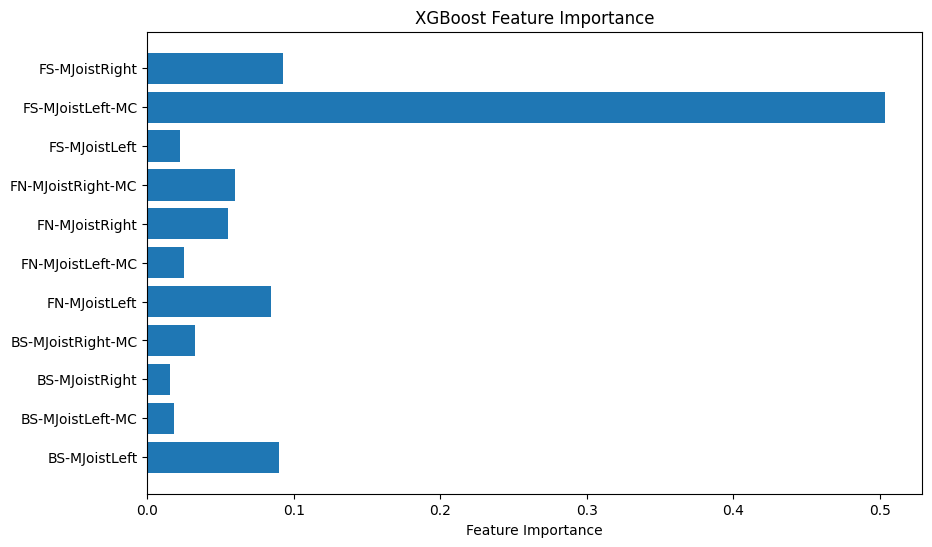

In [12]:
# Feature importance for XGBoost
import matplotlib.pyplot as plt

xgb_importance = xgb_model.feature_importances_

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(xgb_importance)), xgb_importance, align='center')
plt.yticks(np.arange(len(xgb_importance)), X.columns)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()


In [13]:
import pandas as pd

# Step 1: Prepare new data for predictions
# Make sure to include all features used in the model training
new_data = pd.DataFrame({
    'feature1': [10.5],  # Replace with actual value for feature1
    'feature2': [3.4],    # Replace with actual value for feature2
    'feature3': [20.0],   # Replace with actual value for feature3
    'feature4': [5.5],    # Replace with actual value for feature4
    'feature5': [12.0],   # Replace with actual value for feature5
    'feature6': [7.5],    # Replace with actual value for feature6
    'feature7': [9.0],    # Replace with actual value for feature7
    'feature8': [6.1],    # Replace with actual value for feature8
    'feature9': [4.2],    # Replace with actual value for feature9
    'feature10': [8.3],   # Replace with actual value for feature10
    'feature11': [15.7],   # Replace with actual value for feature11
})

# Ensure new_data has the same structure as X used in model training
print("New data structure:")
print(new_data)

# Assuming xgb_model and lgb_model are already defined and trained
# Step 2: Make predictions on the new data using the trained models
new_data_predictions_xgb = xgb_model.predict(new_data)
new_data_predictions_lgb = lgb_model.predict(new_data)

# Step 3: Output the predictions
print("Predictions from XGBoost on new data:", new_data_predictions_xgb)
print("Predictions from LightGBM on new data:", new_data_predictions_lgb)


New data structure:
   feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0      10.5       3.4      20.0       5.5      12.0       7.5       9.0   

   feature8  feature9  feature10  feature11  
0       6.1       4.2        8.3       15.7  
Predictions from XGBoost on new data: [0.49569377]
Predictions from LightGBM on new data: [0.4195088]


In [14]:
import joblib

# Save models
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(lgb_model, 'lgb_model.pkl')

# Load models
loaded_xgb_model = joblib.load('xgb_model.pkl')
loaded_lgb_model = joblib.load('lgb_model.pkl')

# Make predictions with loaded models
loaded_predictions = loaded_xgb_model.predict(X_test)


In [15]:
import joblib
import numpy as np

# Step 1: Save models
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(lgb_model, 'lgb_model.pkl')

# Step 2: Load models
loaded_xgb_model = joblib.load('xgb_model.pkl')
loaded_lgb_model = joblib.load('lgb_model.pkl')

# Step 3: Make predictions with loaded models
loaded_predictions_xgb = loaded_xgb_model.predict(X_test)
loaded_predictions_lgb = loaded_lgb_model.predict(X_test)

# Step 4: Output the predictions
print("Predictions from loaded XGBoost model:", loaded_predictions_xgb)
print("Predictions from loaded LightGBM model:", loaded_predictions_lgb)

# Optionally, print out the shapes of the predictions to verify
print("Shape of XGBoost predictions:", loaded_predictions_xgb.shape)
print("Shape of LightGBM predictions:", loaded_predictions_lgb.shape)


Predictions from loaded XGBoost model: [0.45309043 0.3168508  0.08075006 ... 0.3479413  0.06331154 0.36976296]
Predictions from loaded LightGBM model: [0.45831204 0.32229197 0.0791835  ... 0.33960332 0.07168575 0.35836659]
Shape of XGBoost predictions: (3822,)
Shape of LightGBM predictions: (3822,)


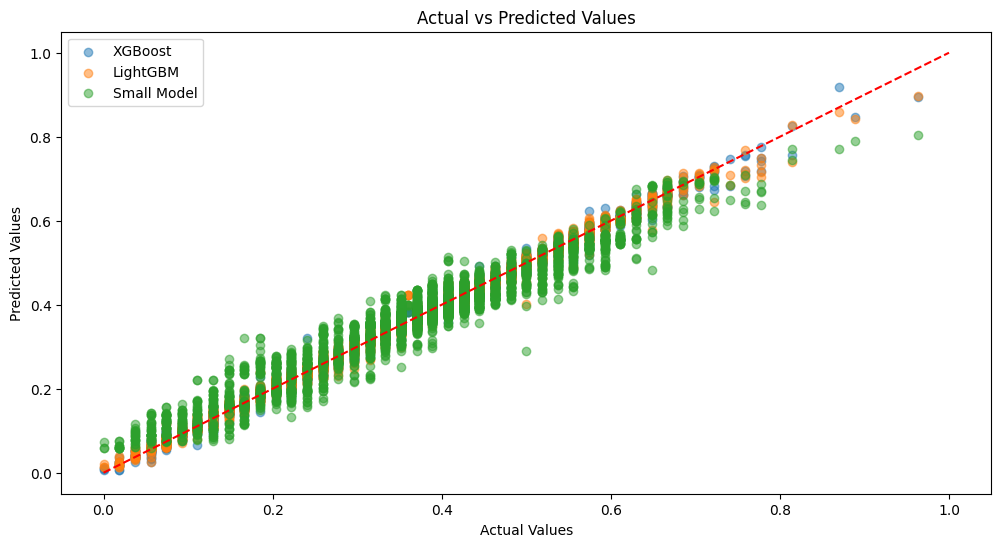

In [16]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_xgb, label='XGBoost', alpha=0.5)
plt.scatter(y_test, y_pred_lgb, label='LightGBM', alpha=0.5)
plt.scatter(y_test, y_pred_small, label='Small Model', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


In [17]:
import joblib

# Save models
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(lgb_model, 'lgb_model.pkl')


['lgb_model.pkl']